In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from oasis.functions import deconvolve
from scipy.stats import pearsonr
from scipy.linalg import logm

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer
import utils.sulfur.constant as const

from utils.cell_spike_fetcher import CellSpikeFetcher
from utils.useful_tool import is_all_zeros_constant_array
from utils.cofiring_graph_generator import CofiringGraphGenerator

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

non_engram_shock_cells = {
    'ID181106CreA': ['C000', 'C007', 'C009', 'C059', 'C076', 'C084', 'C086', 'C099', 'C101', 'C116', 'C120', 'C124', 'C141', 'C143', 'C145', 'C153', 'C164', 'C173', 'C175', 'C197', 'C198', 'C228', 'C234', 'C235', 'C284', 'C303', 'C306', 'C310', 'C317', 'C325', 'C327', 'C328', 'C336', 'C362', 'C377', 'C442', 'C459', 'C476', 'C479', 'C480', 'C487', 'C491', 'C493', 'C494', 'C519'],
    'ID181106CreB': ['C000', 'C003', 'C009', 'C010', 'C063', 'C066', 'C071', 'C072', 'C073', 'C080', 'C083', 'C088', 'C090', 'C094', 'C100', 'C103', 'C108', 'C109', 'C112', 'C114', 'C115', 'C127', 'C130', 'C131', 'C134', 'C166', 'C168', 'C169', 'C177', 'C178', 'C179', 'C200', 'C202', 'C203', 'C213', 'C230', 'C231', 'C268', 'C279', 'C282', 'C284'],
    'ID181106CreC': ['C002', 'C011', 'C012', 'C016', 'C019', 'C043', 'C045', 'C049', 'C050', 'C054', 'C055', 'C056', 'C058', 'C060', 'C063', 'C070', 'C072', 'C074', 'C076', 'C079', 'C084', 'C086', 'C088', 'C096', 'C105', 'C107', 'C118', 'C127', 'C132', 'C143', 'C144', 'C146', 'C153', 'C155', 'C160', 'C168', 'C186', 'C192', 'C193', 'C194', 'C198', 'C202', 'C205', 'C215', 'C219', 'C224', 'C233', 'C235', 'C237', 'C238', 'C239', 'C241', 'C256', 'C257', 'C262', 'C268', 'C272', 'C276', 'C287', 'C294', 'C295', 'C296'],
    'ID181106CreG': ['C003', 'C004', 'C005', 'C010', 'C011', 'C017', 'C025', 'C063', 'C067', 'C070', 'C071', 'C073', 'C076', 'C089', 'C102', 'C118', 'C126', 'C133', 'C136', 'C142', 'C157', 'C166', 'C177', 'C193', 'C197', 'C199', 'C204', 'C205', 'C210', 'C212', 'C229', 'C232', 'C244', 'C247', 'C249', 'C253', 'C261', 'C273', 'C286', 'C291', 'C293', 'C294', 'C298', 'C302', 'C304', 'C305', 'C309', 'C313', 'C325', 'C338', 'C344', 'C352', 'C353', 'C361', 'C377', 'C385', 'C426', 'C449', 'C458', 'C478'],
    'ID181106CreH': ['C018', 'C021', 'C059', 'C074', 'C081', 'C085', 'C087', 'C125', 'C127', 'C148', 'C160', 'C175', 'C203', 'C218', 'C232', 'C249', 'C252', 'C256', 'C261', 'C268', 'C271', 'C350', 'C361', 'C385', 'C386', 'C395', 'C397', 'C400', 'C404', 'C411', 'C475', 'C490', 'C493', 'C497', 'C498', 'C505', 'C511', 'C520', 'C521', 'C525', 'C529', 'C541', 'C579', 'C594', 'C603', 'C632', 'C636'],
    'ID181106CreI': ['C012', 'C049', 'C061', 'C143', 'C164', 'C166', 'C176', 'C183', 'C214', 'C249', 'C254', 'C256', 'C270', 'C275', 'C281', 'C302', 'C325', 'C326', 'C327', 'C341', 'C352', 'C368'],
    'ID181106CreK': ['C006', 'C045', 'C066', 'C071', 'C075', 'C080', 'C085', 'C102', 'C114', 'C117', 'C123', 'C124', 'C133', 'C136', 'C145', 'C178', 'C180', 'C202', 'C205', 'C206', 'C207', 'C208', 'C233', 'C238', 'C239', 'C243', 'C251', 'C262', 'C267', 'C277', 'C291', 'C297', 'C323', 'C325', 'C341', 'C352', 'C361', 'C376', 'C380', 'C399', 'C403', 'C411', 'C424', 'C428'],
    'ID181106CreL': ['C008', 'C015', 'C020', 'C021', 'C037', 'C040', 'C044', 'C049', 'C061', 'C069', 'C073', 'C074', 'C075', 'C082', 'C085', 'C123', 'C125', 'C126', 'C128', 'C129', 'C132', 'C133', 'C144', 'C150', 'C155', 'C162', 'C173', 'C180', 'C185', 'C196', 'C203', 'C209', 'C211', 'C213', 'C216', 'C224', 'C231', 'C236', 'C243', 'C255', 'C270', 'C273', 'C283', 'C298', 'C312', 'C315', 'C323', 'C332', 'C341', 'C343', 'C344', 'C346', 'C350', 'C353', 'C357', 'C373', 'C414', 'C416', 'C424', 'C439', 'C445', 'C456', 'C461', 'C463', 'C475', 'C498', 'C501'],
    'ID181106CreN': ['C008', 'C022', 'C028', 'C044', 'C048', 'C057', 'C062', 'C069', 'C079', 'C089', 'C098', 'C123', 'C144', 'C168', 'C186', 'C201', 'C204', 'C213', 'C217', 'C227', 'C228', 'C239', 'C261', 'C267', 'C288', 'C290', 'C301', 'C306', 'C309', 'C321', 'C343', 'C355', 'C391', 'C395', 'C397', 'C402', 'C404', 'C410', 'C412', 'C413', 'C416', 'C425', 'C429', 'C441', 'C463', 'C469', 'C490', 'C506', 'C511', 'C517'],
    'ID181106CreQ': ['C000', 'C001', 'C006', 'C009', 'C019', 'C022', 'C033', 'C034', 'C040', 'C042', 'C050', 'C055', 'C057', 'C059', 'C061', 'C070', 'C076', 'C089', 'C092', 'C098', 'C108', 'C118', 'C121', 'C122', 'C123', 'C127', 'C132', 'C134', 'C137', 'C168', 'C169', 'C173', 'C179', 'C181', 'C192', 'C202', 'C205', 'C207', 'C209', 'C214', 'C217', 'C239', 'C260', 'C263', 'C281', 'C284', 'C305', 'C308', 'C316', 'C325', 'C332', 'C333', 'C335', 'C336', 'C343', 'C347', 'C354', 'C362', 'C365', 'C368', 'C372', 'C374', 'C375', 'C380', 'C387', 'C398', 'C412', 'C417', 'C421', 'C426', 'C431', 'C434', 'C455', 'C456', 'C463', 'C464', 'C470', 'C485', 'C491']
}

In [3]:
all_shock_cells = {}
for animal_name in engram_shock_cells:
    all_shock_cells[animal_name] = engram_shock_cells[animal_name] + non_engram_shock_cells[animal_name]

In [4]:
%%time
animal_name = const.ANIMAL_NAMES[0]
shock_cells = all_shock_cells[animal_name]
a1_csv = ContextDataCSV(animal_name, 'A1postES')
a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
a1_shock_matrix = a1_matrix.loc[:, shock_cells]

generator = CofiringGraphGenerator(a1_shock_matrix, a1_csv.is_engram)
graph = generator.run(80, 100)
graph

CPU times: user 13.3 s, sys: 263 ms, total: 13.6 s
Wall time: 3.02 s


Text(0.5, 1.0, 'A1 shock#1')

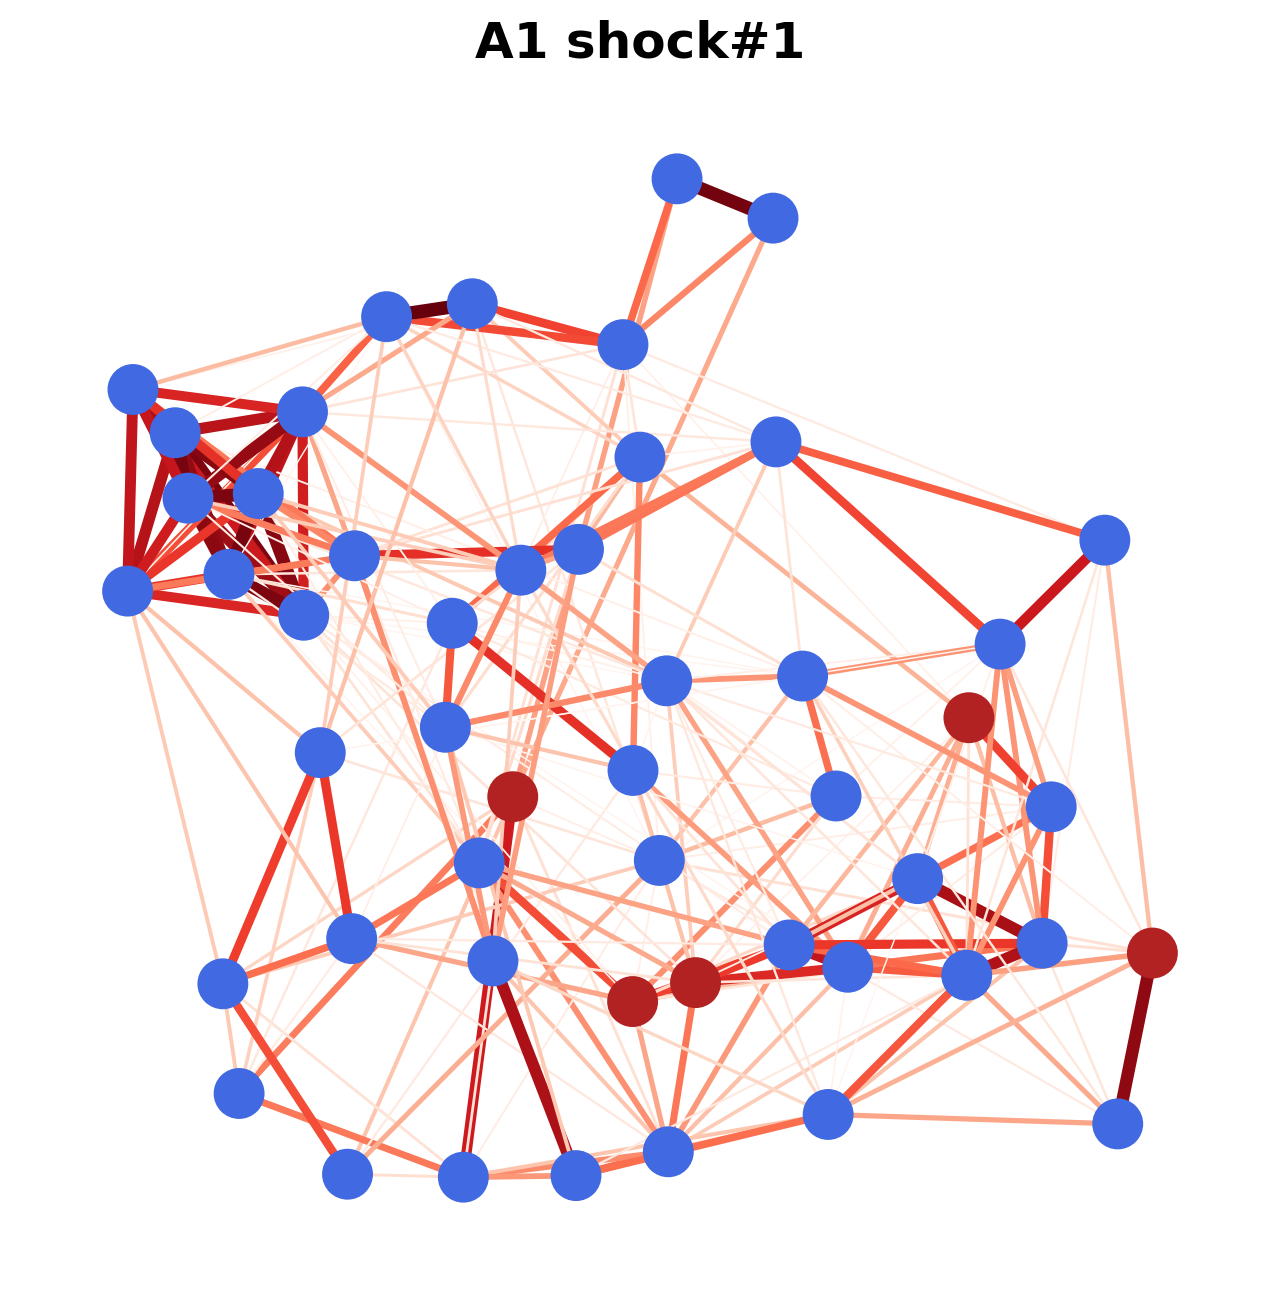

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
pos = nx.spring_layout(graph, seed=123)
edges, weights = zip(*nx.get_edge_attributes(graph, 'weight').items())
node_colors = [options["color"] for cell_name, options in graph.nodes(data=True)]
nx.draw(graph, pos, node_color=node_colors, edgelist=edges, edge_color=weights, width=(np.array(weights) * 5), edge_cmap=plt.cm.Reds, ax=ax)
ax.set_title('A1 shock#1', fontsize=18, fontweight='bold')

animal name: ID181106CreA
animal name: ID181106CreB
animal name: ID181106CreC
animal name: ID181106CreG
animal name: ID181106CreH
animal name: ID181106CreI
animal name: ID181106CreK
animal name: ID181106CreL
animal name: ID181106CreN
animal name: ID181106CreQ
CPU times: user 6min 54s, sys: 6.45 s, total: 7min 1s
Wall time: 2min 16s


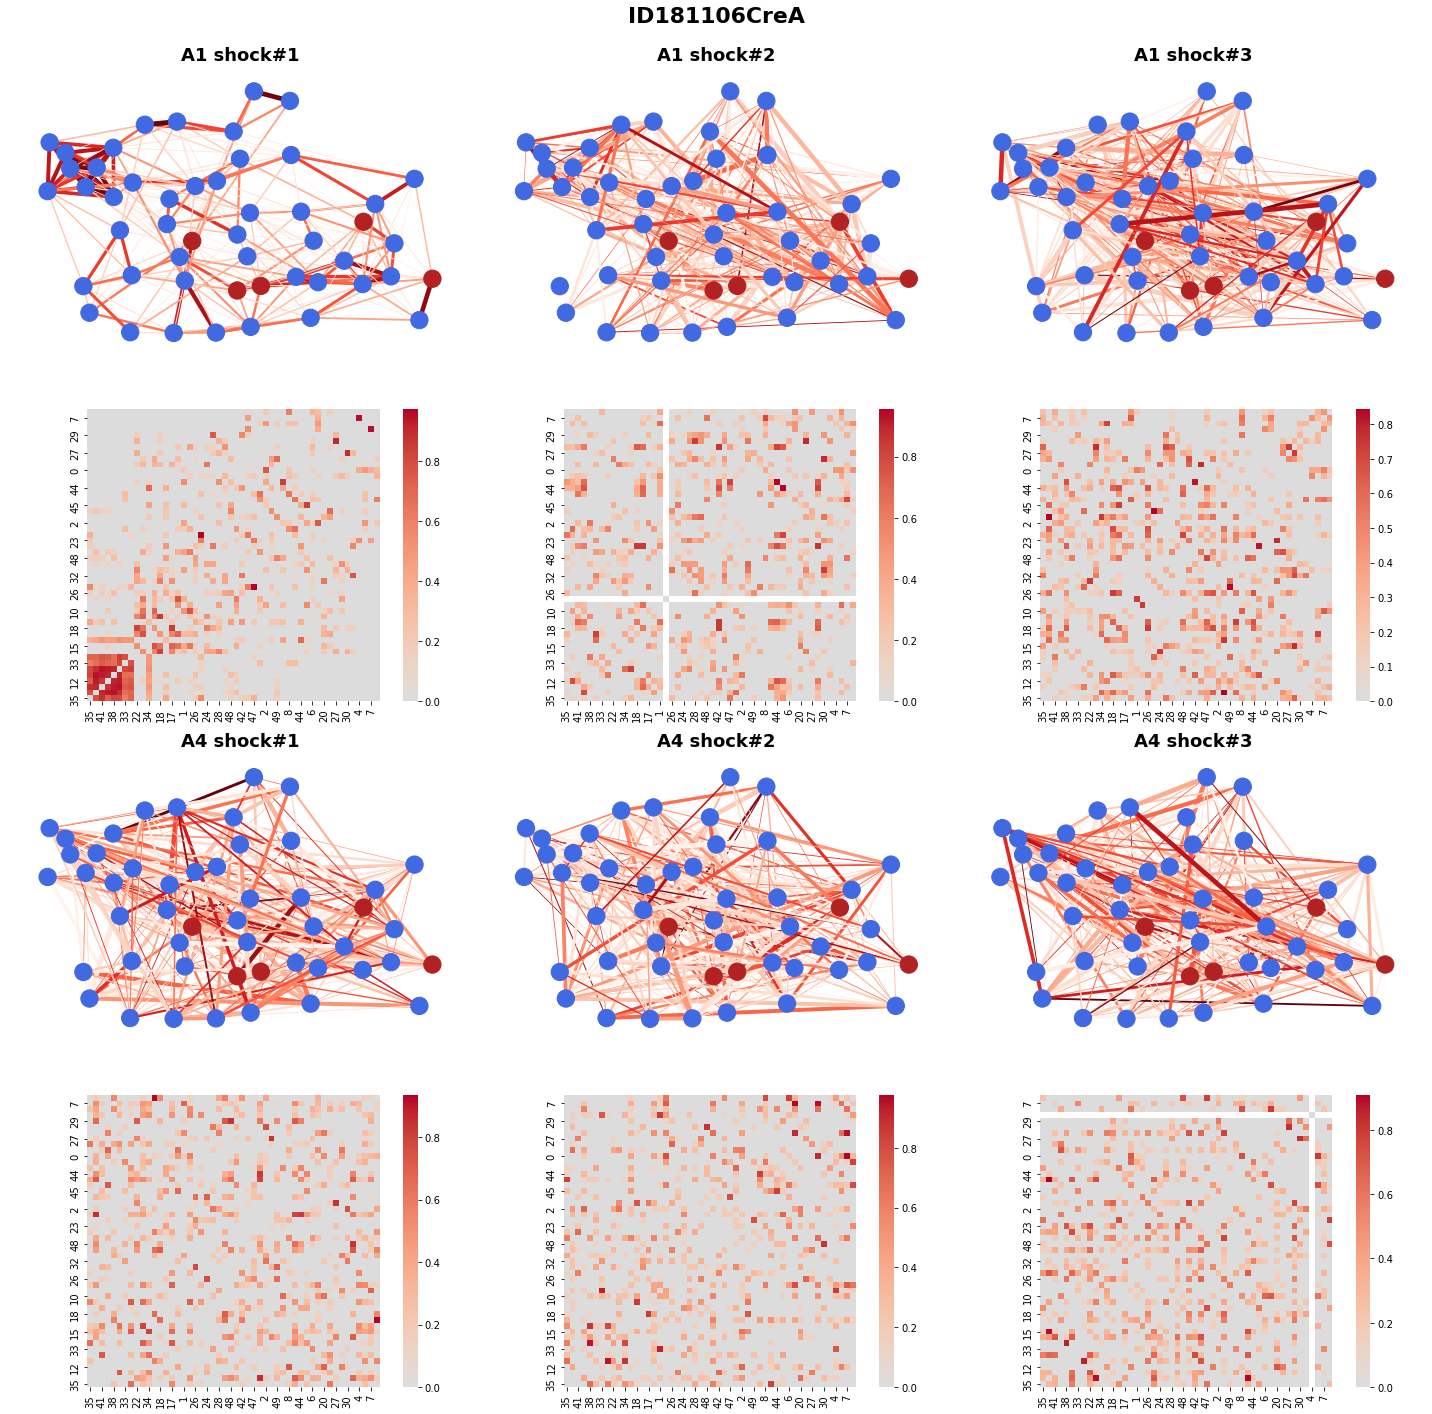

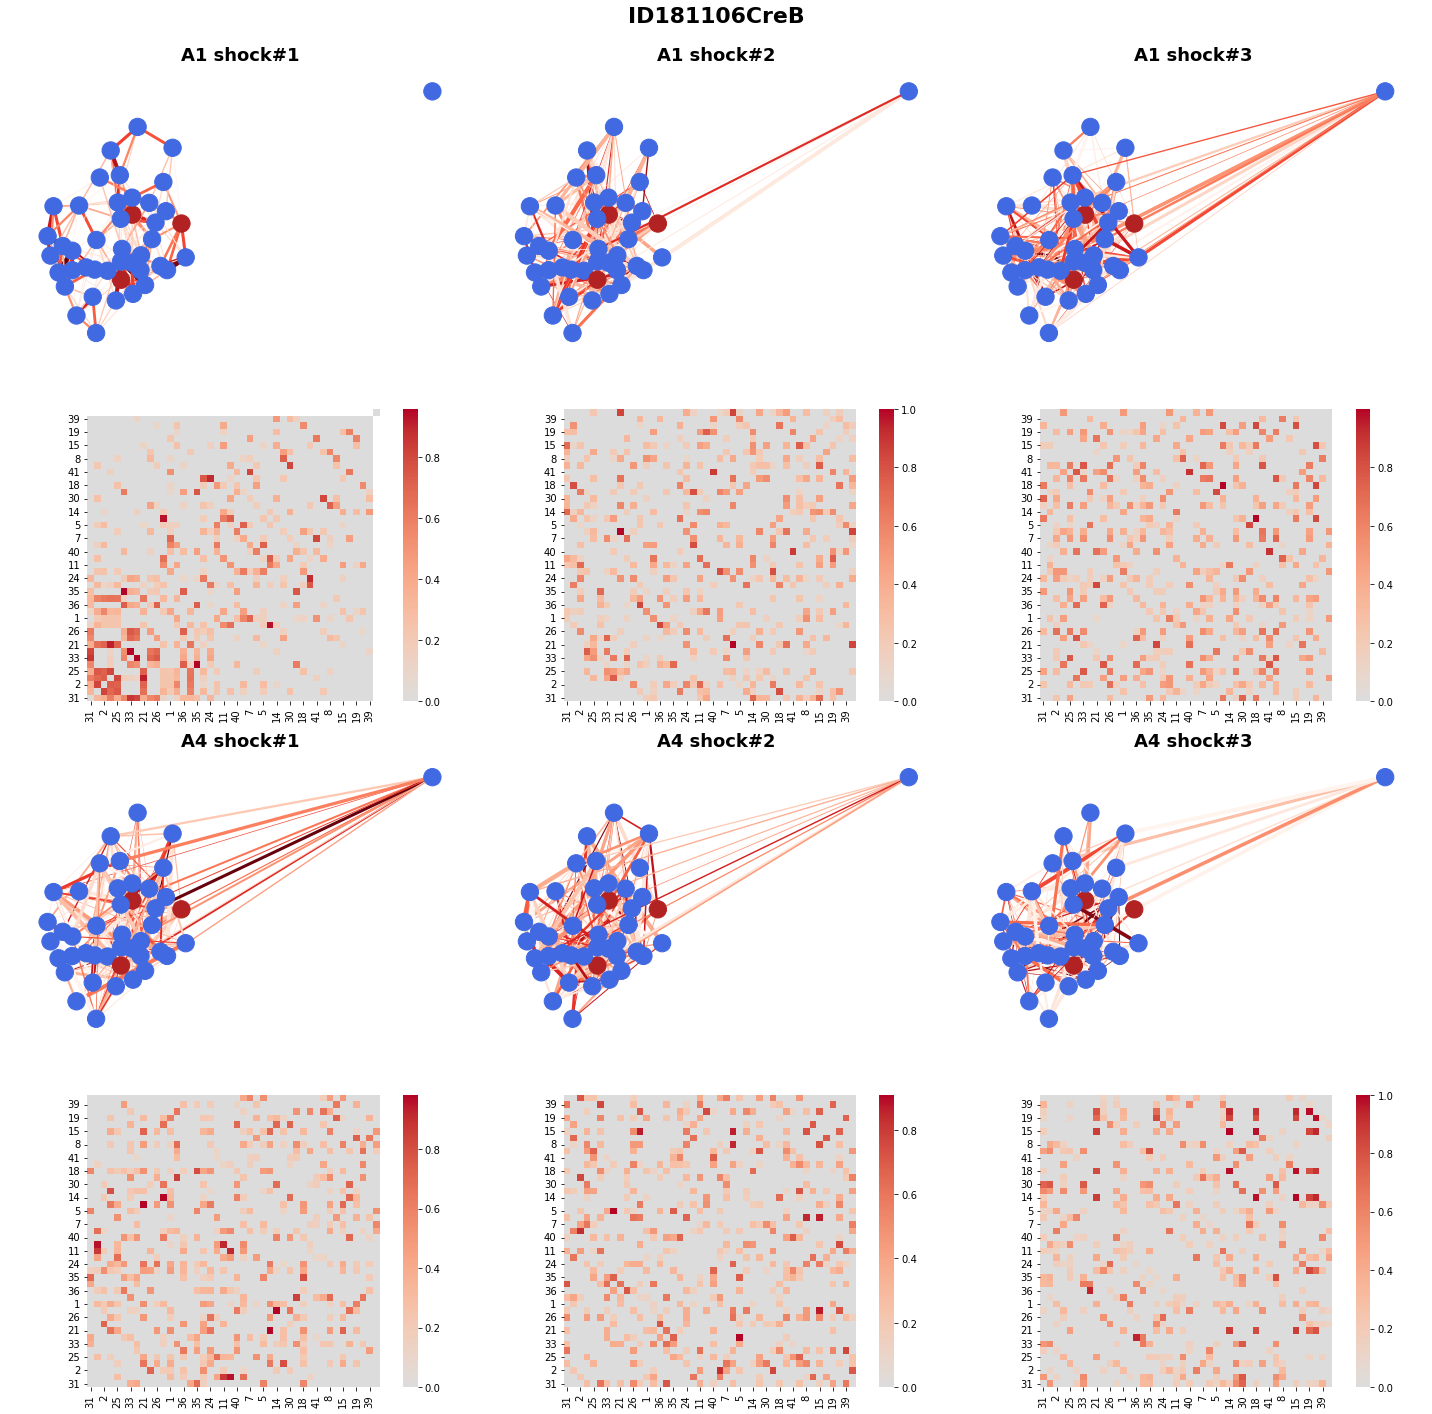

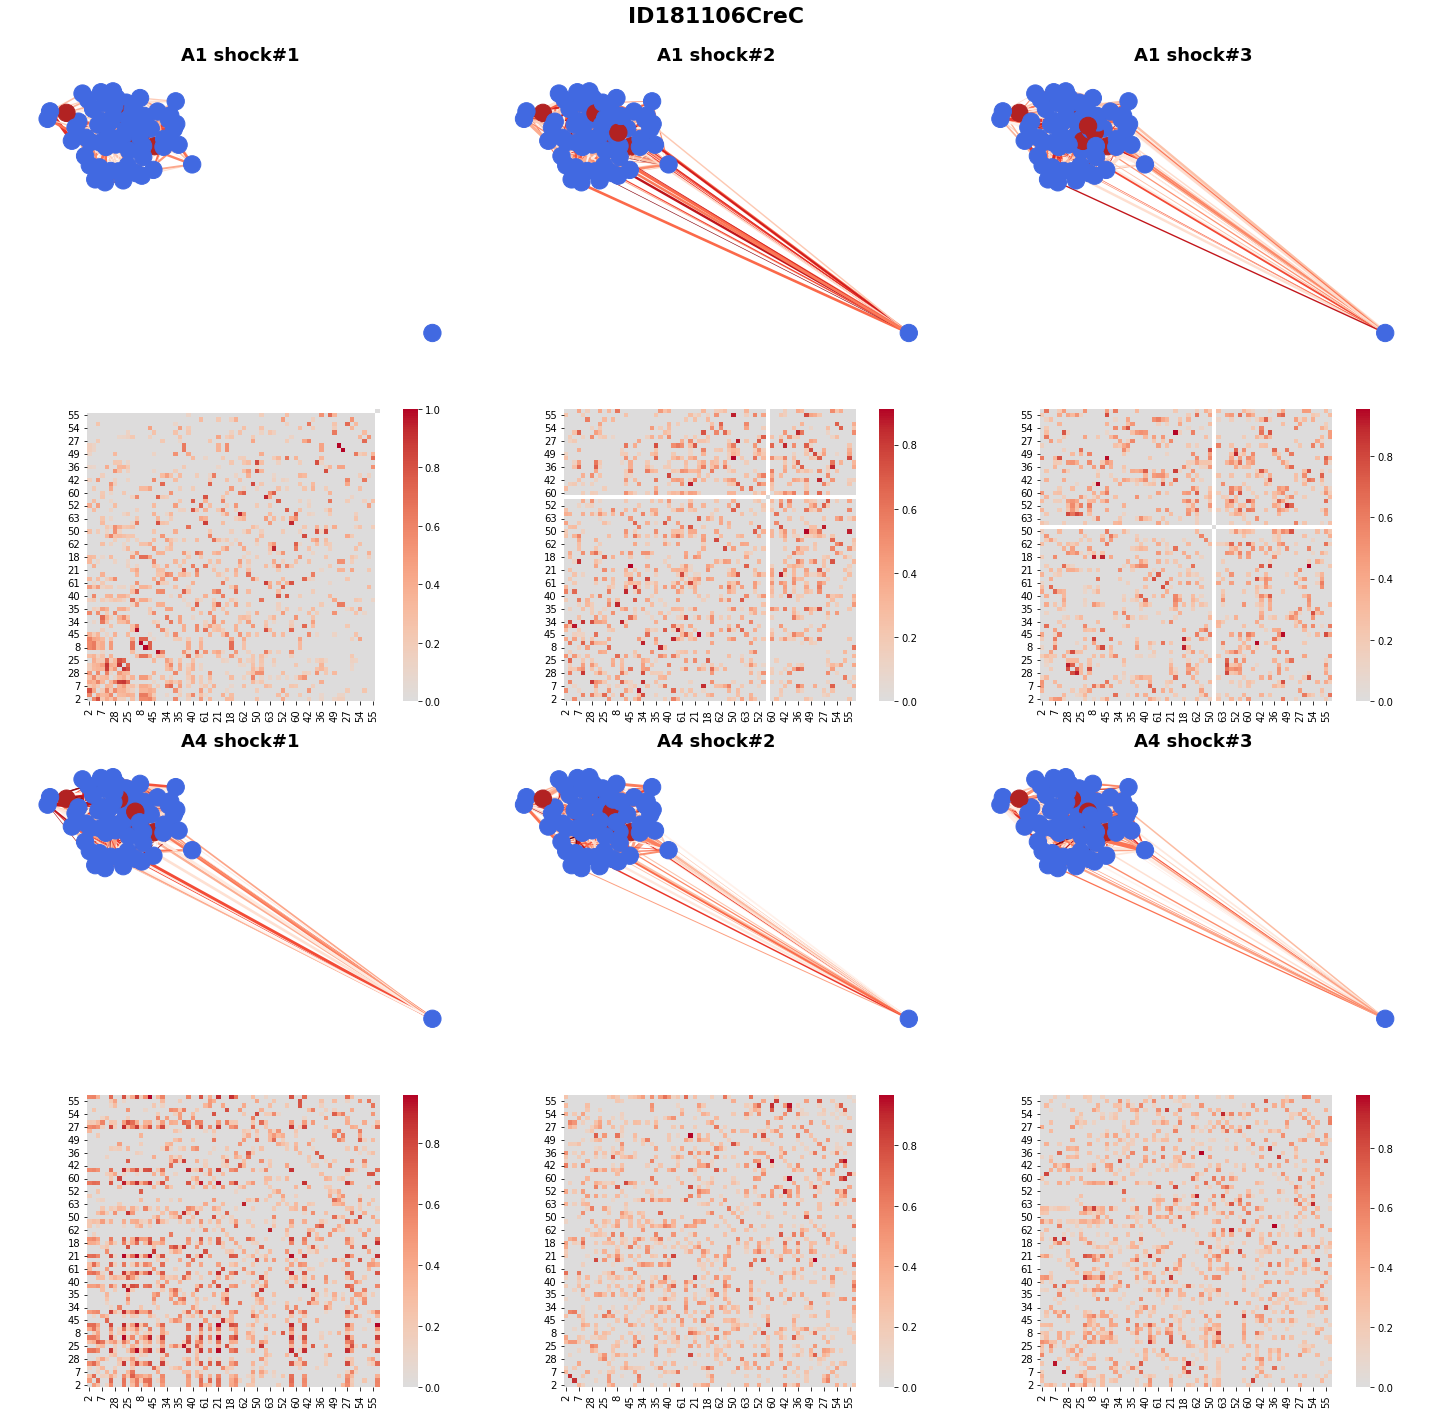

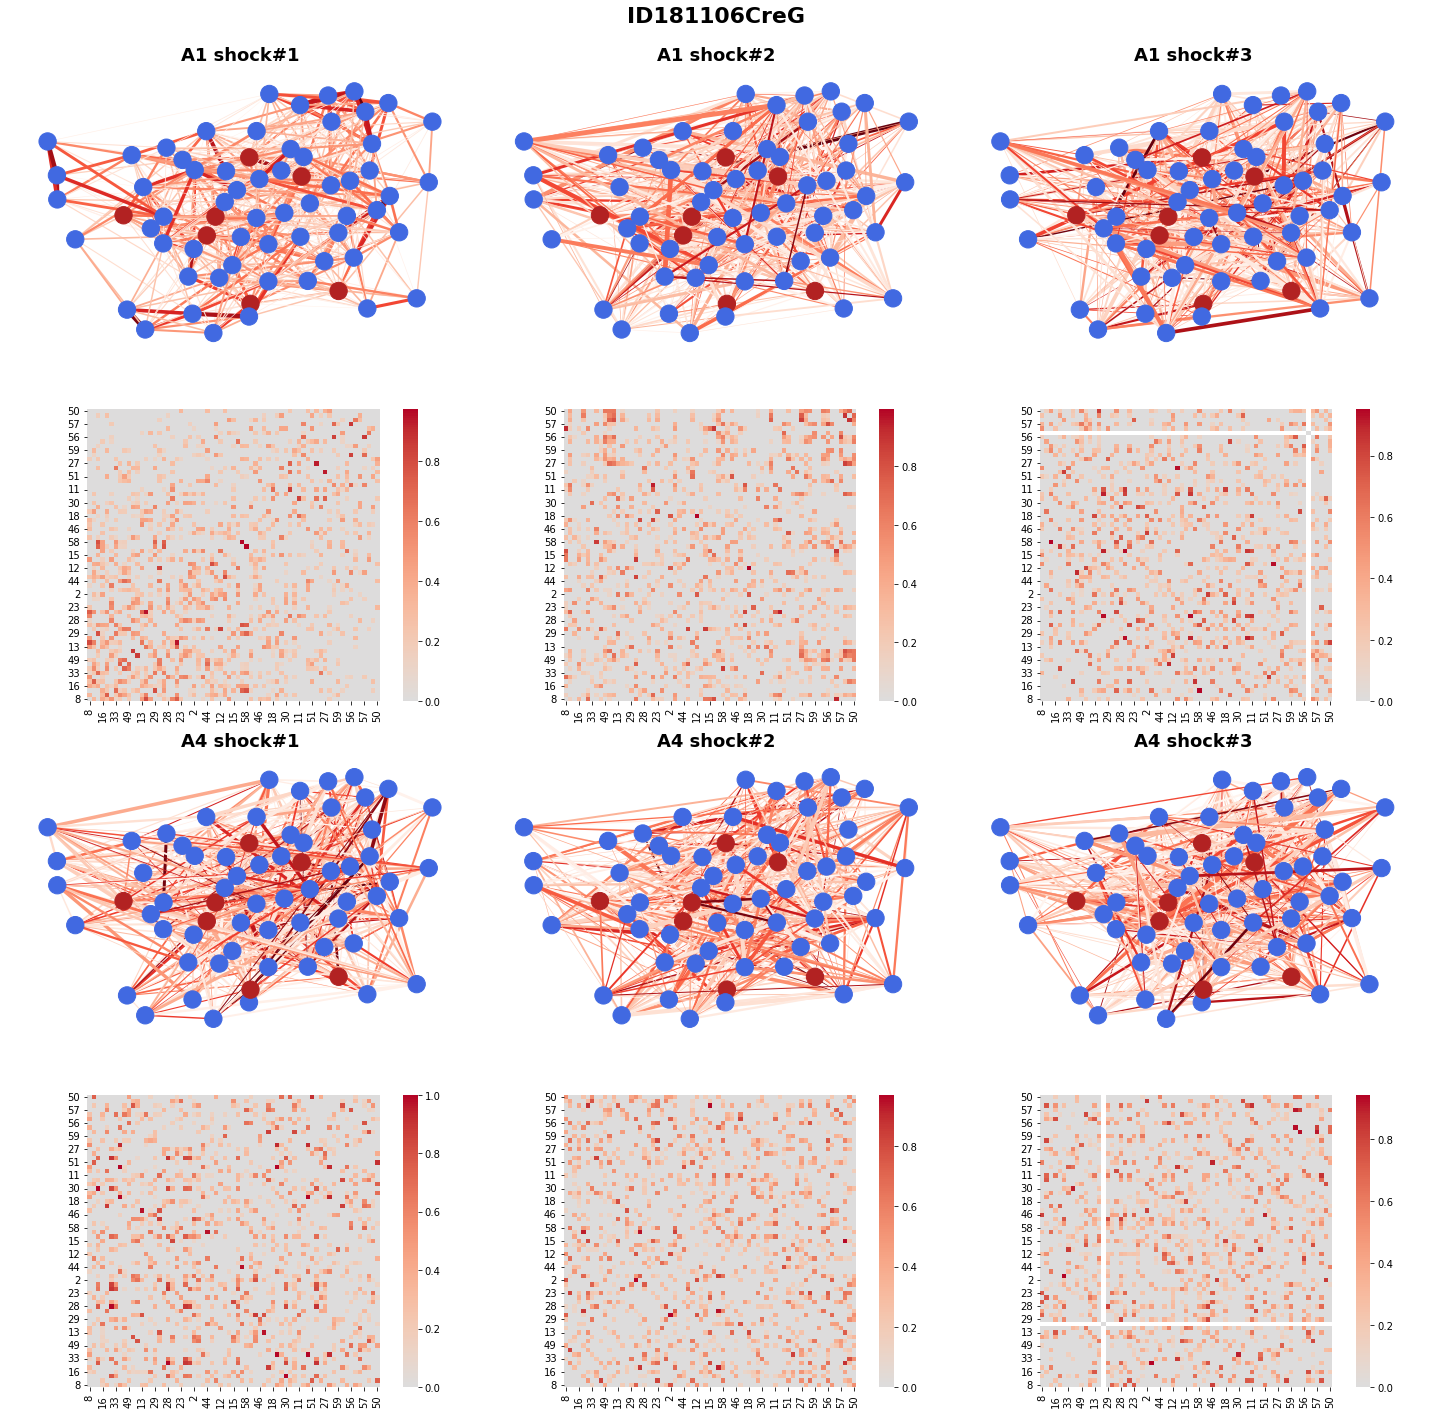

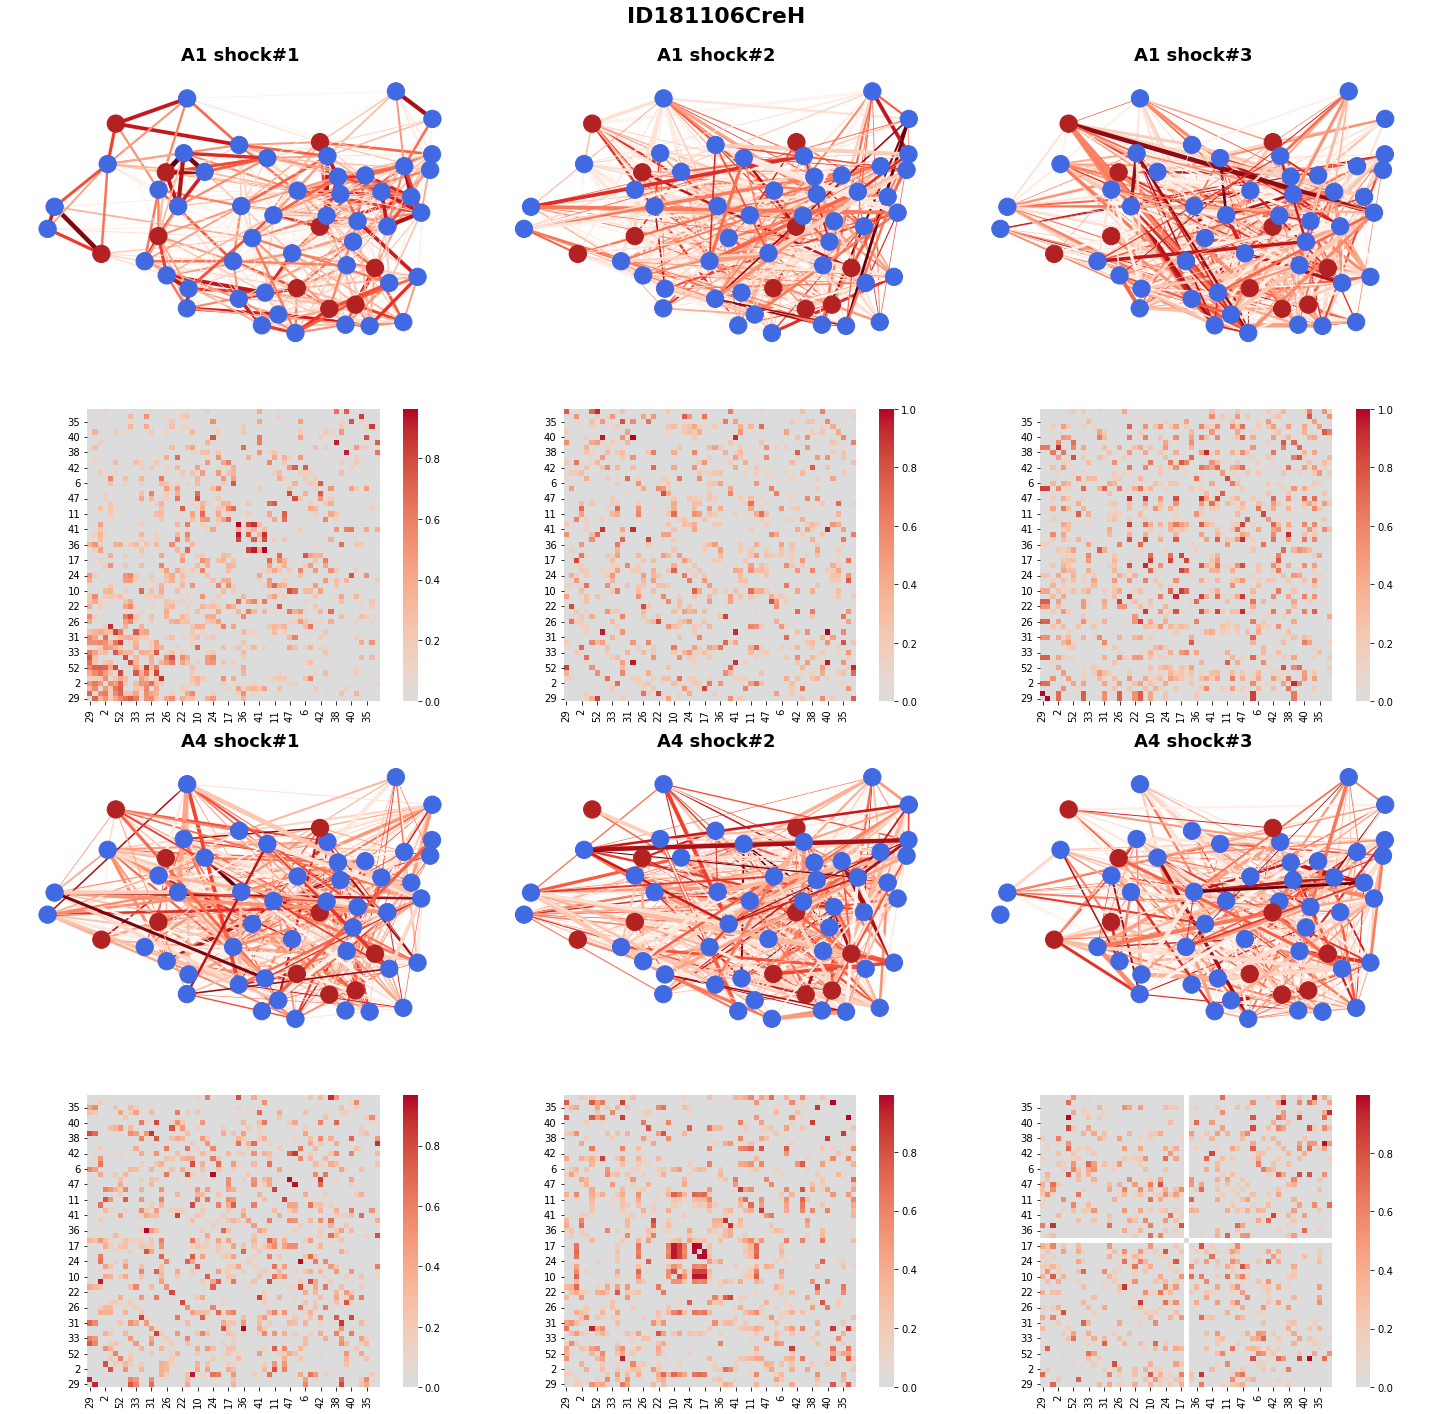

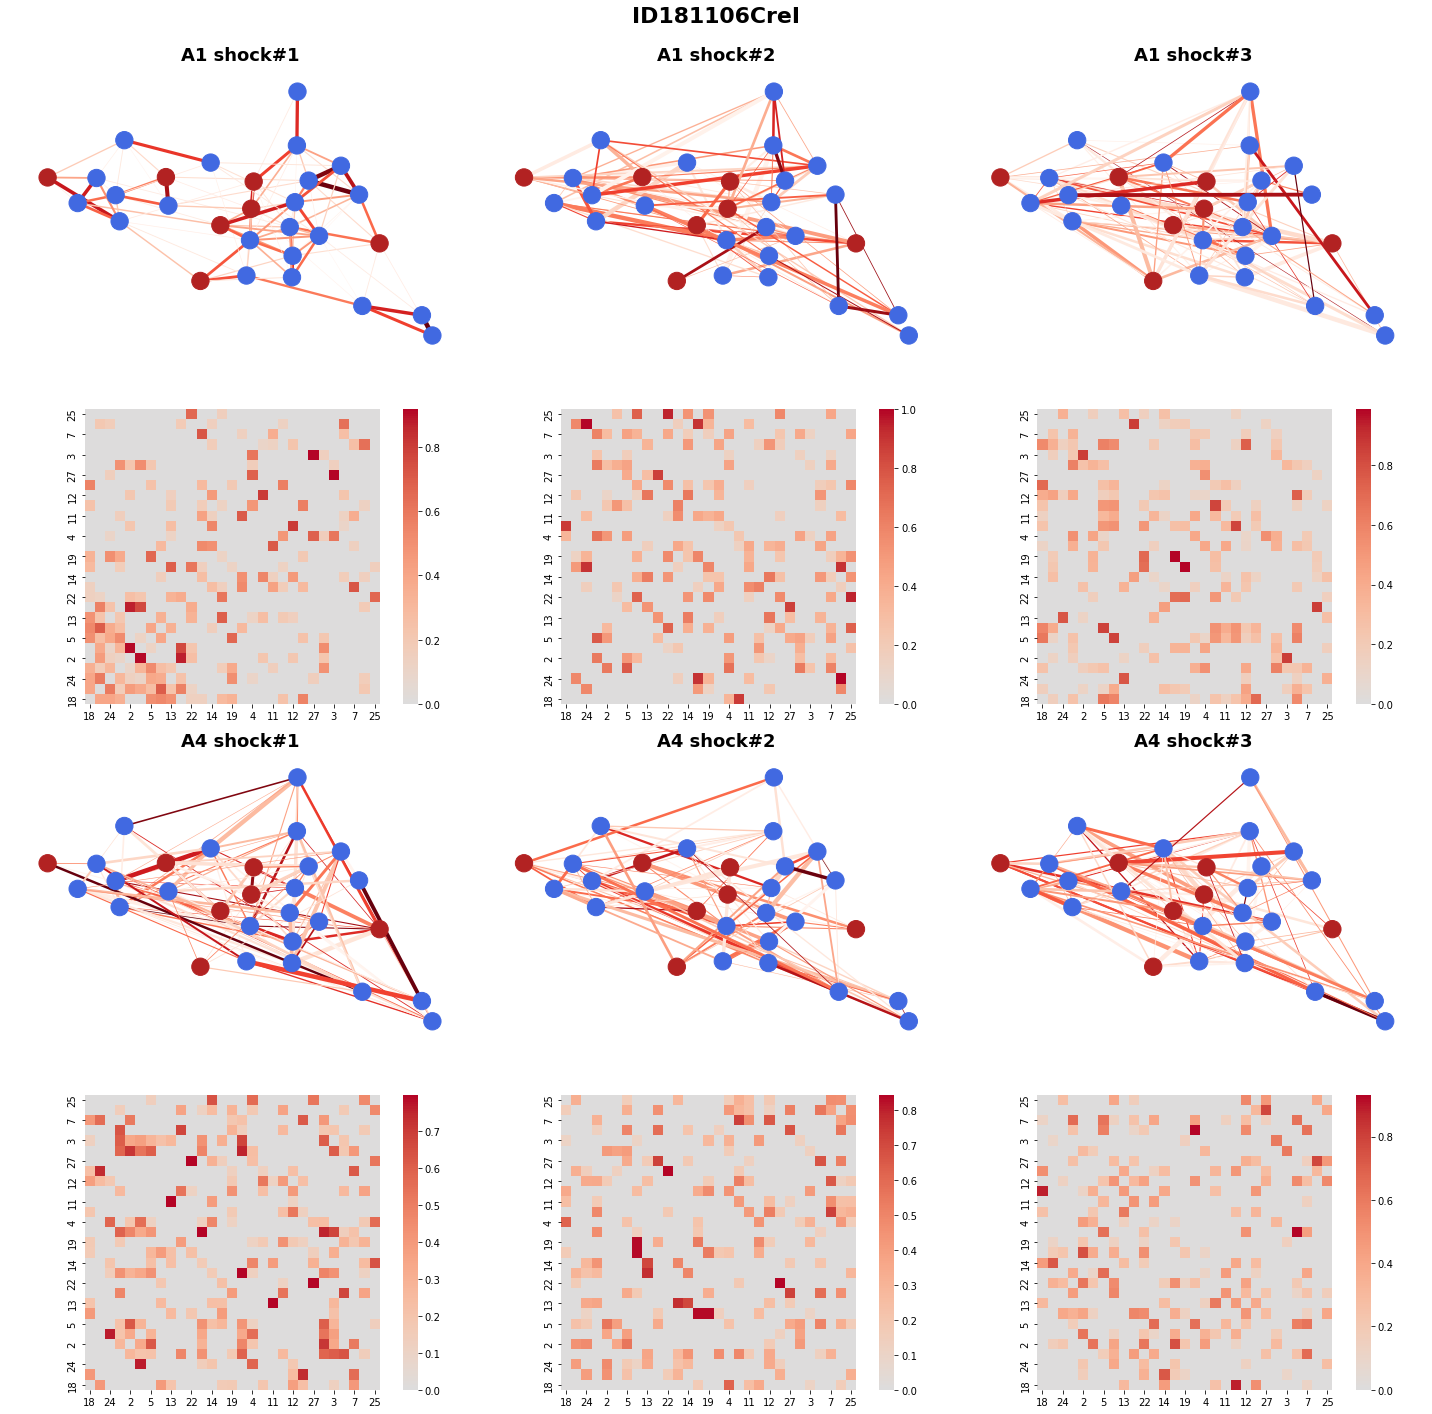

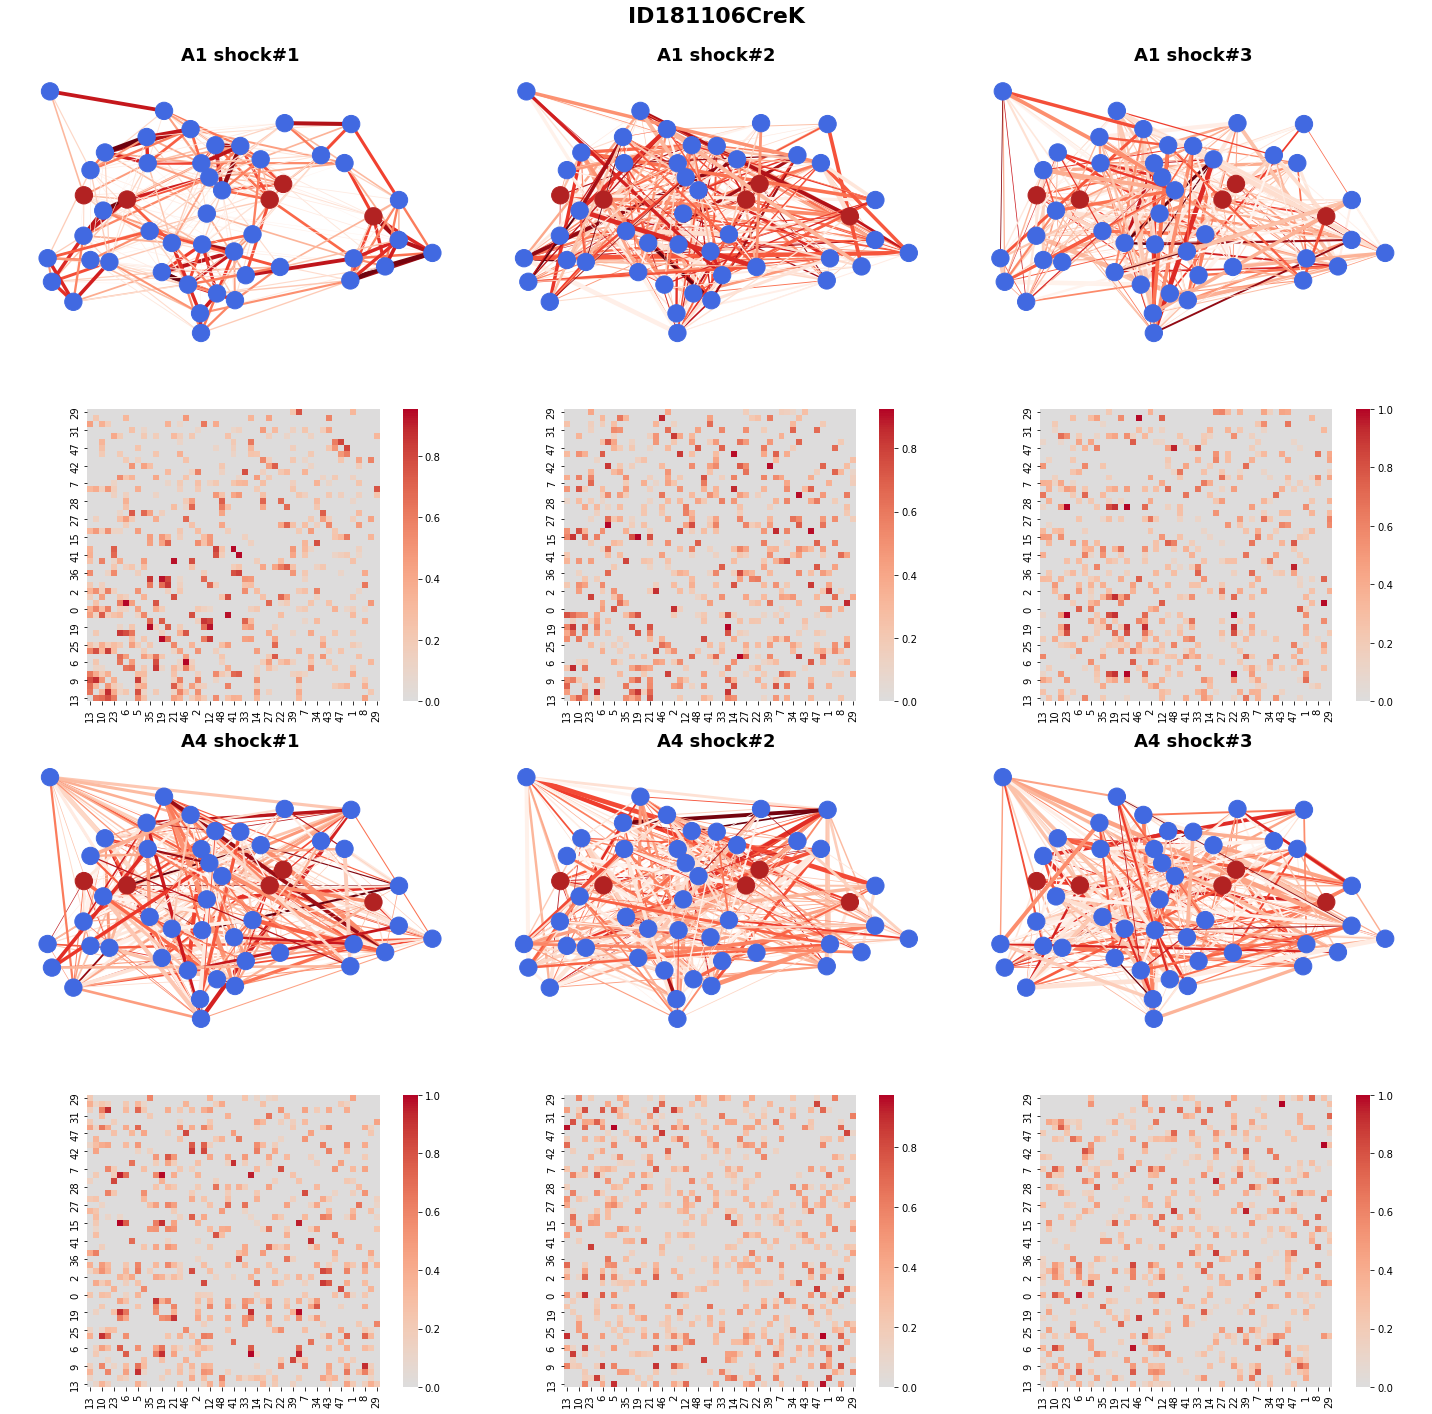

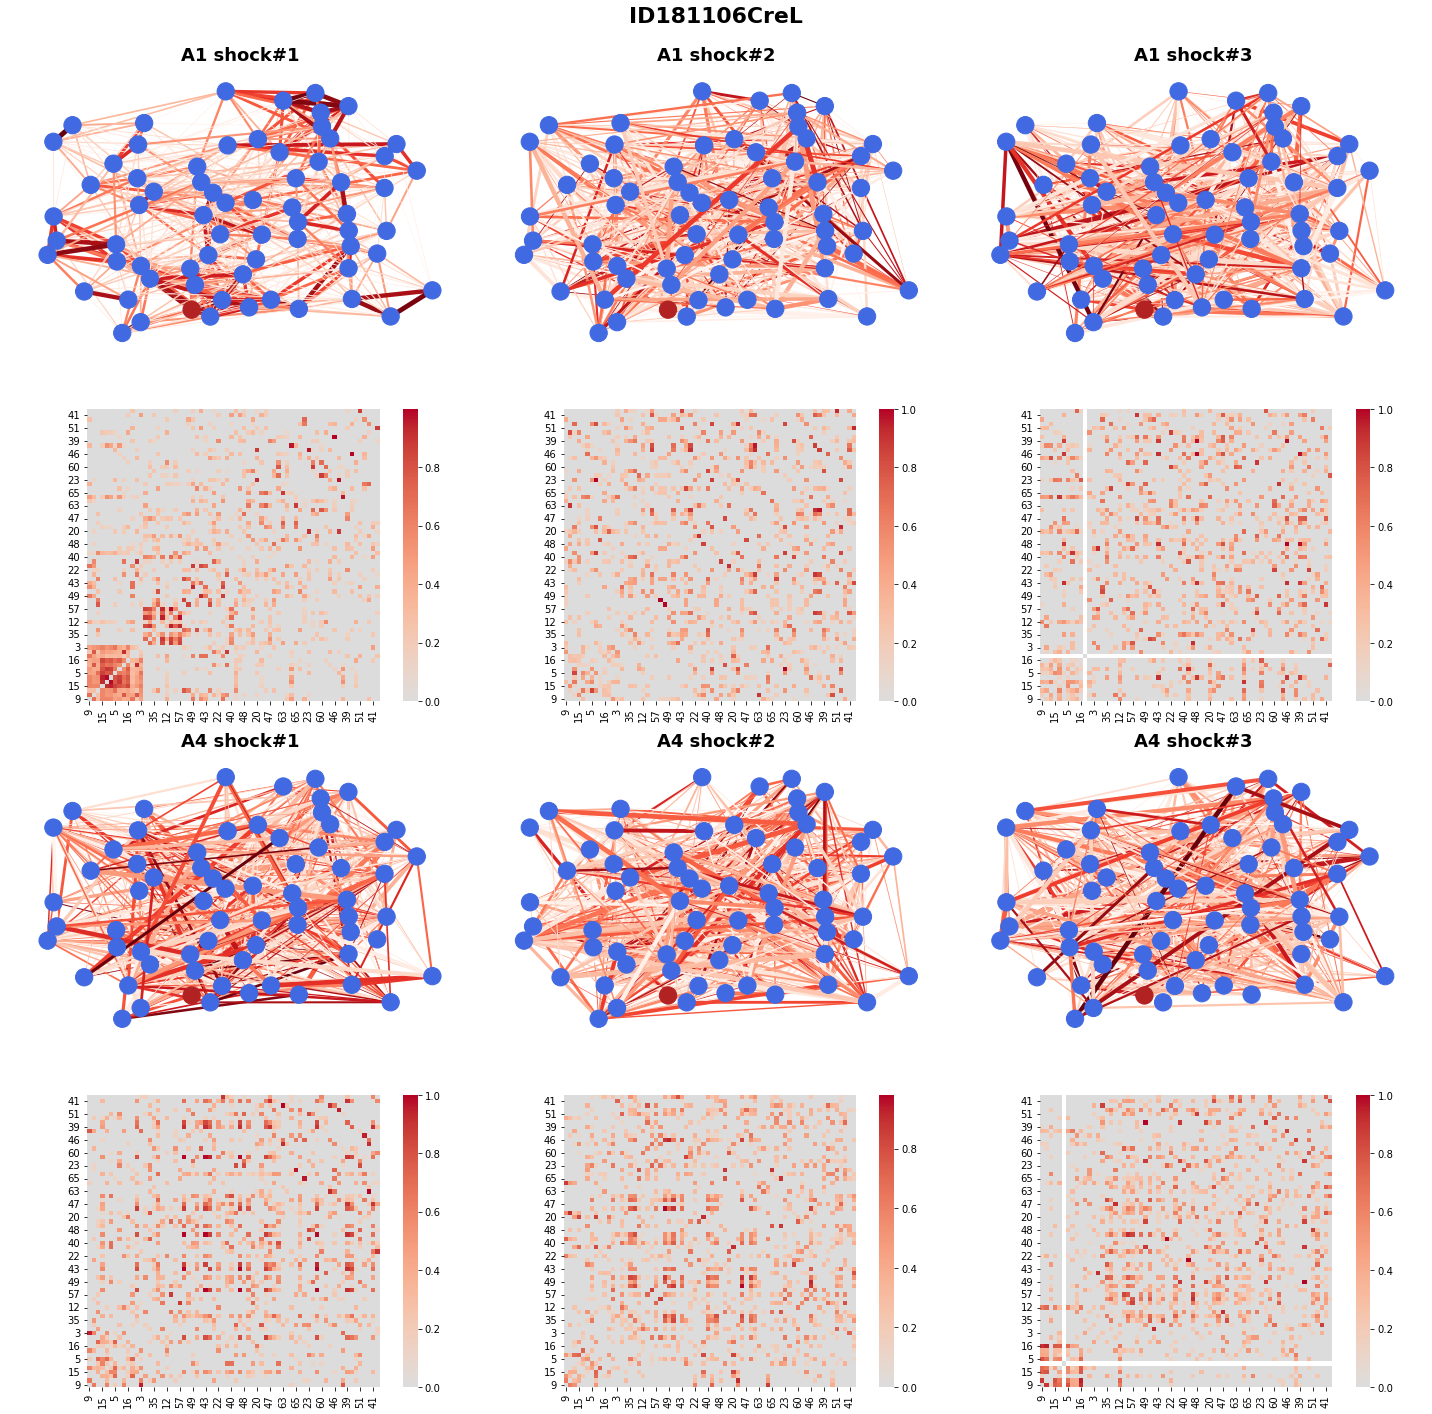

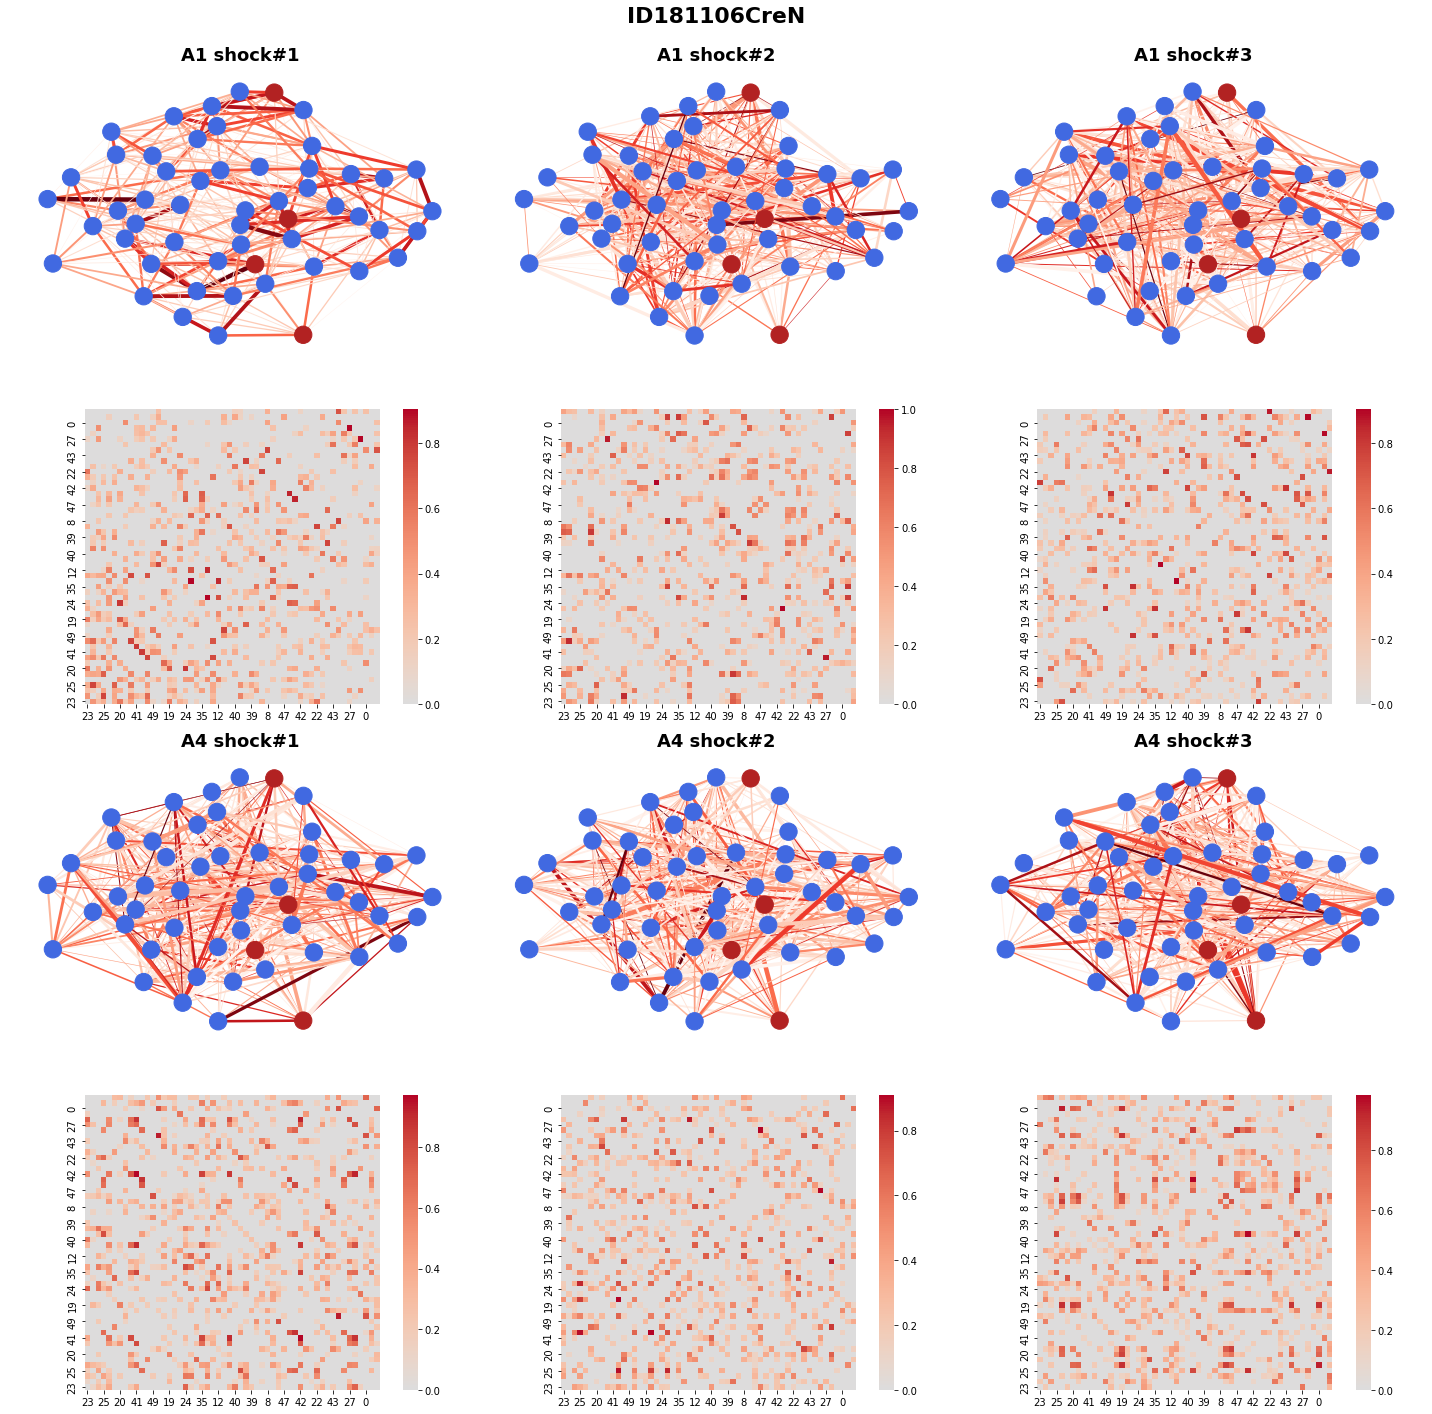

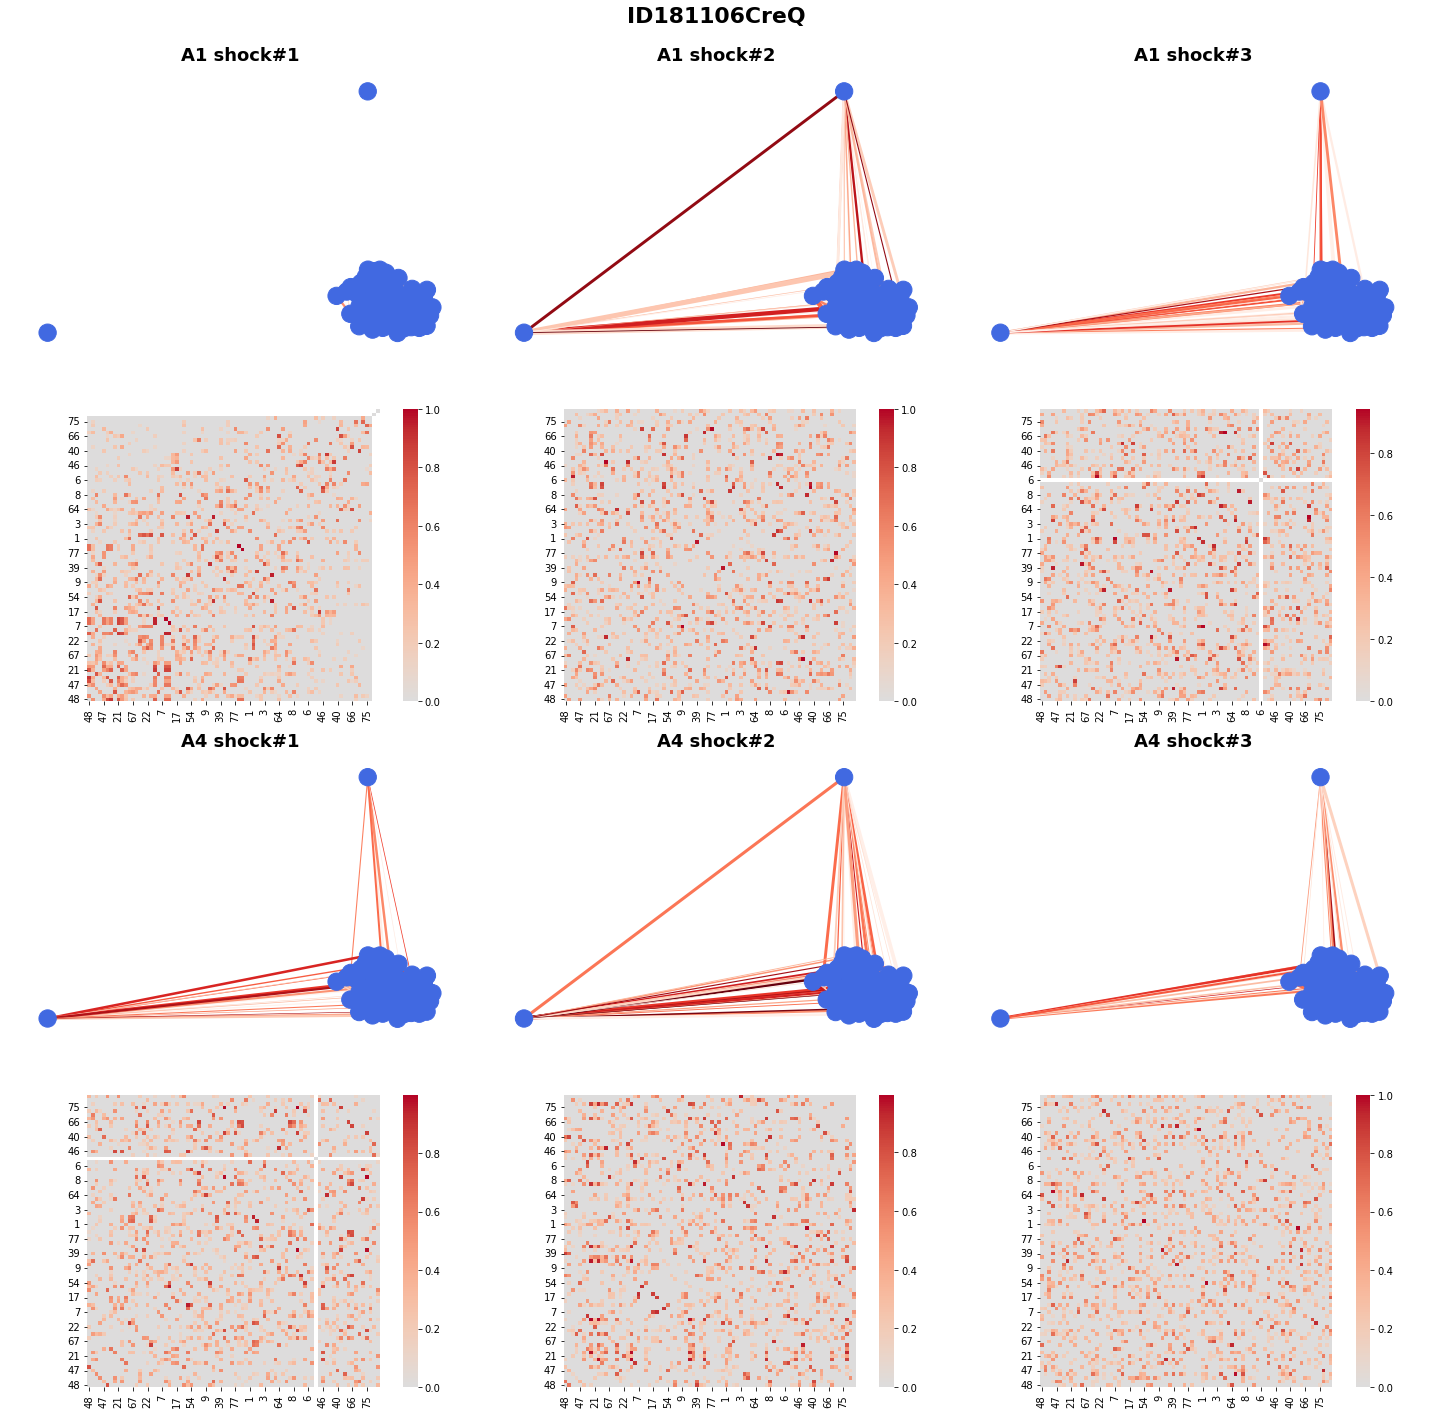

In [8]:
%%time

for animal_name in const.ANIMAL_NAMES:
    try:
        print('animal name: %s' % animal_name)
        
        shock_cells = all_shock_cells[animal_name]
        a1_csv = ContextDataCSV(animal_name, 'A1postES')
        a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
        a1_shock_matrix = a1_matrix.loc[:, shock_cells]
        
        a1_generator = CofiringGraphGenerator(a1_shock_matrix, a1_csv.is_engram)
        a1_1_graph = a1_generator.run(80, 100)
        a1_2_graph = a1_generator.run(980, 1000)
        a1_3_graph = a1_generator.run(1880, 1900)
        
        a4_csv = ContextDataCSV(animal_name, 'A4postES')
        a4_matrix = MatrixOptimizer(a4_csv.data_frame).divide_sd()
        a4_shock_matrix = a4_matrix.loc[:, shock_cells]
        
        a4_generator = CofiringGraphGenerator(a4_shock_matrix, a4_csv.is_engram)
        a4_1_graph = a4_generator.run(80, 100)
        a4_2_graph = a4_generator.run(980, 1000)
        a4_3_graph = a4_generator.run(1880, 1900)
        
        fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20))
        
        pos = nx.spring_layout(a1_1_graph, seed=123)
        
        adjacency_matrixes = []
        
        a1_1_edges, a1_1_weights = zip(*nx.get_edge_attributes(a1_1_graph, 'weight').items())
        a1_1_node_colors = [options["color"] for cell_name, options in a1_1_graph.nodes(data=True)]
        nx.draw(a1_1_graph, pos, node_color=a1_1_node_colors, edgelist=a1_1_edges, edge_color=a1_1_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[0][0])
        axes[0][0].set_title('A1 shock#1', fontsize=18, fontweight='bold')
        
        a1_1_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_1_graph).toarray())
        adjacency_matrixes.append(a1_1_adjacency_matrix.copy(deep=True))
        ordered_high_weight_index = a1_1_adjacency_matrix.sum().sort_values(ascending=False).index
        a1_1_adjacency_matrix = a1_1_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        
        ax = sns.heatmap(a1_1_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][0])
        ax.invert_yaxis()
        
        a1_2_edges, a1_2_weights = zip(*nx.get_edge_attributes(a1_2_graph, 'weight').items())
        a1_2_node_colors = [options["color"] for cell_name, options in a1_2_graph.nodes(data=True)]
        nx.draw(a1_2_graph, pos, node_color=a1_2_node_colors, edgelist=a1_2_edges, edge_color=a1_2_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[0][1])
        axes[0][1].set_title('A1 shock#2', fontsize=18, fontweight='bold')
        
        a1_2_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_2_graph).toarray())
        adjacency_matrixes.append(a1_2_adjacency_matrix.copy(deep=True))
        a1_2_adjacency_matrix = a1_2_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        
        ax = sns.heatmap(a1_2_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][1])
        ax.invert_yaxis()
        
        a1_3_edges, a1_3_weights = zip(*nx.get_edge_attributes(a1_3_graph, 'weight').items())
        a1_3_node_colors = [options["color"] for cell_name, options in a1_3_graph.nodes(data=True)]
        nx.draw(a1_3_graph, pos, node_color=a1_3_node_colors, edgelist=a1_3_edges, edge_color=a1_3_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[0][2])
        axes[0][2].set_title('A1 shock#3', fontsize=18, fontweight='bold')
        
        a1_3_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_3_graph).toarray())
        adjacency_matrixes.append(a1_3_adjacency_matrix.copy(deep=True))
        a1_3_adjacency_matrix = a1_3_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        
        ax = sns.heatmap(a1_3_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][2])
        ax.invert_yaxis()
        
        a4_1_edges, a4_1_weights = zip(*nx.get_edge_attributes(a4_1_graph, 'weight').items())
        a4_1_node_colors = [options["color"] for cell_name, options in a4_1_graph.nodes(data=True)]
        nx.draw(a4_1_graph, pos, node_color=a4_1_node_colors, edgelist=a4_1_edges, edge_color=a4_1_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[2][0])
        axes[2][0].set_title('A4 shock#1', fontsize=18, fontweight='bold')
        
        a4_1_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_1_graph).toarray())
        adjacency_matrixes.append(a4_1_adjacency_matrix.copy(deep=True))
        a4_1_adjacency_matrix = a4_1_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        
        ax = sns.heatmap(a4_1_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][0])
        ax.invert_yaxis()
        
        a4_2_edges, a4_2_weights = zip(*nx.get_edge_attributes(a4_2_graph, 'weight').items())
        a4_2_node_colors = [options["color"] for cell_name, options in a4_2_graph.nodes(data=True)]
        nx.draw(a4_2_graph, pos, node_color=a4_2_node_colors, edgelist=a4_2_edges, edge_color=a4_2_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[2][1])
        axes[2][1].set_title('A4 shock#2', fontsize=18, fontweight='bold')
        
        a4_2_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_2_graph).toarray())
        adjacency_matrixes.append(a4_2_adjacency_matrix.copy(deep=True))
        a4_2_adjacency_matrix = a4_2_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        
        ax = sns.heatmap(a4_2_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][1])
        ax.invert_yaxis()
        
        a4_3_edges, a4_3_weights = zip(*nx.get_edge_attributes(a4_3_graph, 'weight').items())
        a4_3_node_colors = [options["color"] for cell_name, options in a4_3_graph.nodes(data=True)]
        nx.draw(a4_3_graph, pos, node_color=a4_3_node_colors, edgelist=a4_3_edges, edge_color=a4_3_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Reds, ax=axes[2][2])
        axes[2][2].set_title('A4 shock#3', fontsize=18, fontweight='bold')
        
        a4_3_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_3_graph).toarray())
        adjacency_matrixes.append(a4_3_adjacency_matrix.copy(deep=True))
        a4_3_adjacency_matrix = a4_3_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
        ax = sns.heatmap(a4_3_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][2])
        ax.invert_yaxis()
        
        #topological_distance_df_index = ['A1 shock#1', 'A1 shock#2', 'A1 shock#3', 'A4 shock#1', 'A4 shock#2', 'A4 shock#3']
        #topological_distance_df = pd.DataFrame(index=topological_distance_df_index, columns=topological_distance_df_index)
        
        #for i, base_matrix in enumerate(adjacency_matrixes):
        #    base_n = len(base_matrix)
        #    white_noise = np.random.normal(0.0, 1.0, base_n ** 2).reshape(base_n, base_n)
        #    
        #    for j, compared_matrix in enumerate(adjacency_matrixes):
        #        compared_n = len(compared_matrix)
        #        
        #        #if topological_distance_df.iloc[j, i] is not np.nan:
        #        #    topological_distance_df.iloc[i, j] = topological_distance_df.iloc[j, i]
        #        #    continue
        #        
        #        distances = np.tril(logm(base_matrix) - logm(compared_matrix) + white_noise)
        #        distance = np.linalg.norm(distances)
        #        
        #        topological_distance_df.iloc[i, j] = 1.0 / distance
        #    max_value = topological_distance_df.iloc[i, :].max()
        #    topological_distance_df.iloc[i, :] /= max_value
        #        
        #print(topological_distance_df)
        
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        fig.suptitle(animal_name, fontsize=22, fontweight='bold')
        fig.show()
    except Exception as e:
        print(e)
        fig.clear()